In [1]:
import xarray as xr
import pop_tools
import os
import re
import cftime
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 

In [2]:
temp_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/temp/temp_1281.009.nc'

In [3]:
grid_name = 'POP_gx1v7'
region_defs = {
    'North Atlantic and Nordic Seas': [{'match': {'REGION_MASK': [6, 7, 9]}, 'bounds': {'TLAT': [20., 70.]}}],
    'LabradorSea': [{'match': {'REGION_MASK': [8]}, 'bounds': {'TLAT': [45.0, 66.0]}}]}
mask3d = pop_tools.region_mask_3d(grid_name, region_defs=region_defs, mask_name='North Atlantic and Nordic Seas')
mask3d = mask3d.sum('region')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [4]:
ds = xr.open_dataset(temp_file, decode_times=False)
ds['time'] = xr.decode_cf(ds, use_cftime=True).time
if isinstance(ds.time.values[0], cftime._cftime.DatetimeNoLeap):
    ds['time'] = xr.DataArray(np.array([pd.Timestamp(str(dt)).to_datetime64() for dt in ds.time.values]),
                              dims='time')

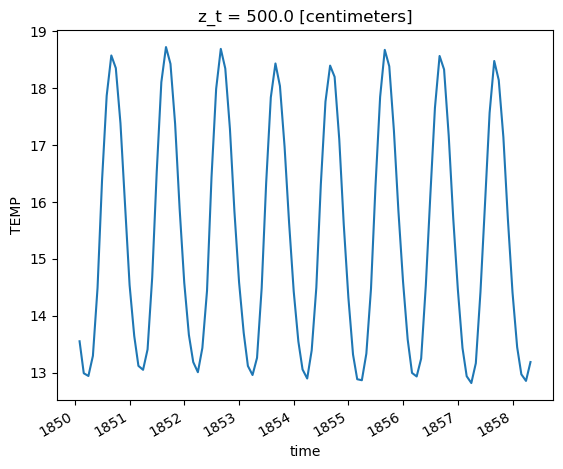

In [5]:
annual_sst = ds['TEMP'].isel(time=slice(0,100), z_t=0).where(mask3d).mean(dim=['nlat', 'nlon'])
annual_sst.plot()

**Find problematic timesteps**

In [6]:
'''
def check_timesteps(file_path):
    ds = xr.open_dataset(file_path)
    total_timesteps = ds.dims['time']
    problematic_timesteps = []

    for i in range(total_timesteps):
        try:
            # Attempt to load data for each timestep
            temp_data = ds['TEMP'].isel(time=i).load()
        except RuntimeError as e:
            print(f"Error processing timestep {i}: {e}")
            problematic_timesteps.append(i)
    
    return problematic_timesteps

# Define your file path
temp_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/temp/temp_1281.009.nc'

# Run the check
problematic_timesteps = check_timesteps(temp_file)
print("Problematic timesteps:", problematic_timesteps)
'''

'\ndef check_timesteps(file_path):\n    ds = xr.open_dataset(file_path)\n    total_timesteps = ds.dims[\'time\']\n    problematic_timesteps = []\n\n    for i in range(total_timesteps):\n        try:\n            # Attempt to load data for each timestep\n            temp_data = ds[\'TEMP\'].isel(time=i).load()\n        except RuntimeError as e:\n            print(f"Error processing timestep {i}: {e}")\n            problematic_timesteps.append(i)\n    \n    return problematic_timesteps\n\n# Define your file path\ntemp_file = \'/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/temp/temp_1281.009.nc\'\n\n# Run the check\nproblematic_timesteps = check_timesteps(temp_file)\nprint("Problematic timesteps:", problematic_timesteps)\n'

**write code that deals with corrupted data**
- if: member throws an error
- implement loop that checks each time step individually 
- faulty values are repalced with last valid value
- values are concatenated
- when finished apply mask and computation

In [6]:
total_time_steps = ds.dims['time']
last_valid_data = None

for t in range(total_time_steps):
    try:
        current_data = ds['TEMP'].isel(z_t=0, time=t)
        current_data.load()
        last_valid_data = current_data
    except RuntimeError as e:
        if last_valid_data is not None:
            print(f"Error at timestep {t}")
            current_data = last_valid_data
        else:
            raise ValueError(f"No valid data at timestep {t}")
            break
    if t == 0:
        combined_data = current_data
    else:
        combined_data = xr.concat([combined_data, current_data], dim='time')

HDF5-DIAG: Error detected in HDF5 (1.10.6) thread 139903705298752:
  #000: H5Dio.c line 199 in H5Dread(): can't read data
    major: Dataset
    minor: Read failed
  #001: H5Dio.c line 603 in H5D__read(): can't read data
    major: Dataset
    minor: Read failed
  #002: H5Dchunk.c line 2293 in H5D__chunk_read(): unable to read raw data chunk
    major: Low-level I/O
    minor: Read failed
  #003: H5Dchunk.c line 3658 in H5D__chunk_lock(): data pipeline read failed
    major: Dataset
    minor: Filter operation failed
  #004: H5Z.c line 1326 in H5Z_pipeline(): filter returned failure during read
    major: Data filters
    minor: Read failed
  #005: H5Zdeflate.c line 123 in H5Z_filter_deflate(): inflate() failed
    major: Data filters
    minor: Unable to initialize object


Error at timestep 1845


In [7]:
ds['combined_TEMP'] = xr.DataArray(combined_data.values, dims=('time', 'nlat', 'nlon'), coords={'time': ds.time})

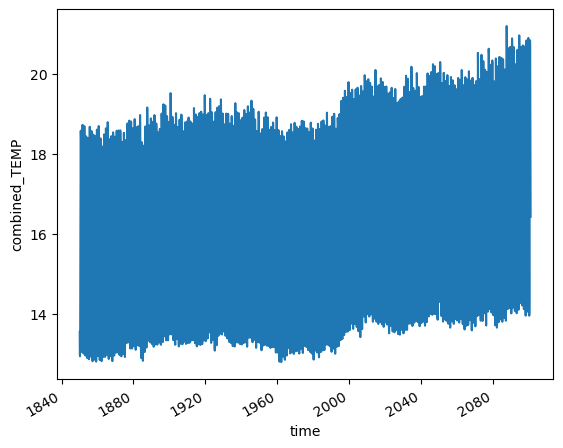

In [8]:
ds['combined_TEMP'].where(mask3d).mean(dim=['nlat', 'nlon']).plot()

In [9]:
annual_sst = ds['combined_TEMP'].where(mask3d).resample(time='AS').mean(dim=['nlat', 'nlon'])

In [11]:
def extract_member_id(filename):
    match = re.search(r'temp_([^.]+(?:\.\d+)?)\.nc', filename)
    return match.group(1) if match else None

In [12]:
member_id = extract_member_id(temp_file)

In [13]:
output_dir = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/all_member_timeseries'
output_path = os.path.join(output_dir, f'annual_sst_member_{member_id}.nc')
annual_sst.to_netcdf(output_path)